<a href="https://colab.research.google.com/github/stiflerGit/CAD-Mammography/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from google.colab import drive
import os
drive.mount('/content/drive')

work_dir = "./drive/My Drive/CNN/"
if not os.path.exists(work_dir):
  os.makedirs(work_dir)

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

train_gray_imgs = np.load("/content/drive/My Drive/CI_FinalProject/Copia di train_img_224.npy")
train_lbls = np.load("drive/My Drive/CI_FinalProject/Copia di train_lab.npy")

val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(train_gray_imgs, train_lbls,
                                                  test_size=val_split, 
                                                  stratify=train_lbls)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))
del(X_train, X_val)
del(y_train, y_val)


X = np.stack((X,)*3, axis=-1)

del(train_gray_imgs)
del(train_lbls)

test_gray_imgs = np.load("drive/My Drive/CI_FinalProject/Copia di public_test_image_224.npy")
test_rgb_imgs = np.stack((test_gray_imgs,)*3, axis=-1)
test_lbls = np.load("drive/My Drive/CI_FinalProject/Copia di public_test_label.npy")

del(test_gray_imgs)

print(X.shape) # 2864 images: it is a small data set
print(X.dtype)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./65536, horizontal_flip=True, vertical_flip=True, validation_split=val_split)

train_iterator = train_datagen.flow(X, y, batch_size=64, subset='training')

validation_iterator = train_datagen.flow(X, y, batch_size=16, subset='validation')
# # validation_iterator = train_datagen.flow(train_rgb_imgs, train_lbls, batch_size=16, subset='validation')

test_datagen = ImageDataGenerator(rescale=1./65536, horizontal_flip=True, vertical_flip=True)

test_iterator = test_datagen.flow(test_rgb_imgs, test_lbls, batch_size=8)

In [0]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# Dense
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))


In [0]:
# from keras.models import Sequential, Model
# from keras import layers

# height = 150
# width = 150

# channels = 3

# num_classes = 2

# model = Sequential()
# model.add(layers.SeparableConv2D(32, 3, activation='relu',
#                                  input_shape=(height, width, channels,)))
# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))
# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))
# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
from keras import optimizers
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

# model.fit_generator?
history = model.fit_generator(train_iterator, steps_per_epoch=35, epochs=60,
#                               callbacks=[early_stopping],
                              validation_data=validation_iterator,
                              validation_steps=35)

In [0]:
model.save_(os.path.join(work_dir, "Dense02.h5"))

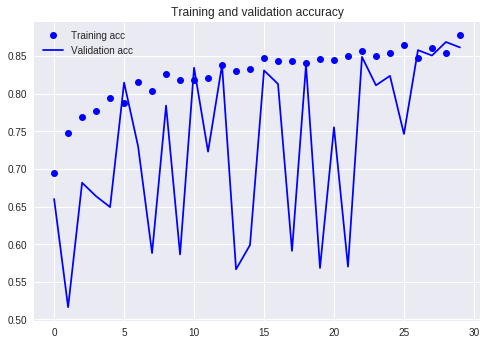

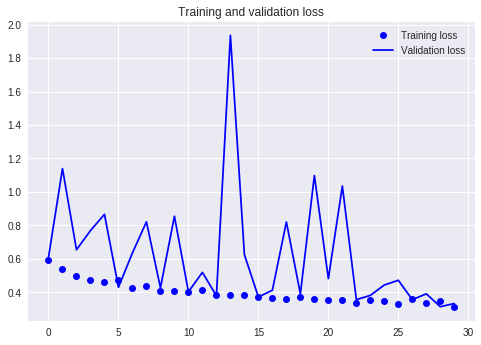

In [0]:
# plot the history
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

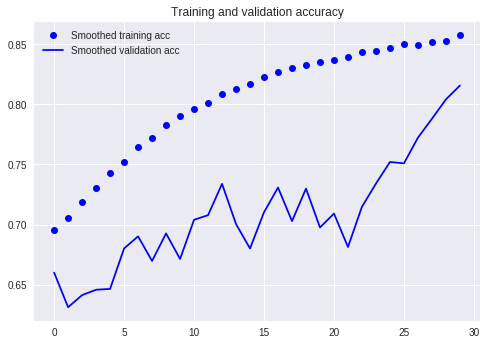

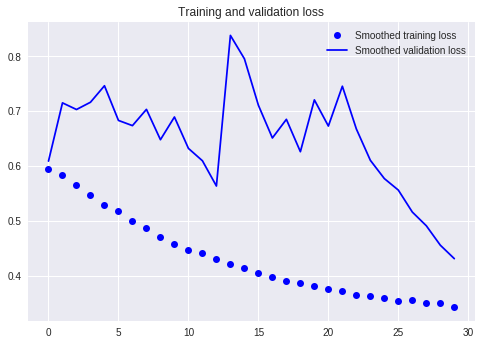

In [0]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
results = model.evaluate_generator(test_iterator, steps=22, verbose=1)

print("test_loss: ", results[0], " test_acc: ", results[1])

22/22 [==============================] - 1s 24ms/step
test_loss:  0.3479648350991986  test_acc:  0.875
